# Zillow Analysis

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

## Business Problem

A real estate investment firm is interested in knowing the top three best New Jersey counties to invest in based on return on investment (ROI).  

## Load Data for Analysis

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

## Data Preprocessing

In [5]:
#Convert date columns to datetime objects
def get_datetimes(df):
    non_dt_cols = []
    dt_cols = []
    
    for c in df.columns:
        if c[0].isnumeric():
            dt_cols.append(c)
        else:
            non_dt_cols.append(c)
    #print(non_dt_cols)
    #print(dt_cols)
    dt_cols = list(pd.to_datetime(dt_cols, format = '%Y-%m'))
    
    df.columns = non_dt_cols + dt_cols
    return df

In [6]:
df = get_datetimes(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Reshape from Wide to Long Format

In [8]:
#Function to melt dataframe with datetime columns
def melt_data(df):
    melted = pd.melt(
        df,
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
        var_name='time')
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
#Updated dataframe
melted_df = melt_data(df)
melted_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [10]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  int64         
 2   City        object        
 3   State       object        
 4   Metro       object        
 5   CountyName  object        
 6   SizeRank    int64         
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


## Seperate New Jersey Data

In [11]:
#Select NJ data for analysis
nj_df = melted_df[melted_df['State'] == 'NJ']
nj_df.set_index('time', inplace=True)

In [12]:
nj_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0


In [13]:
nj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133030 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    133030 non-null  int64  
 1   RegionName  133030 non-null  int64  
 2   City        133030 non-null  object 
 3   State       133030 non-null  object 
 4   Metro       133030 non-null  object 
 5   CountyName  133030 non-null  object 
 6   SizeRank    133030 non-null  int64  
 7   value       133030 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 9.1+ MB


In [14]:
#Change columns from int64 to string
nj_df['RegionID'] = nj_df['RegionID'].astype(str)
nj_df['RegionName'] = nj_df['RegionName'].astype(str)
nj_df['SizeRank'] = nj_df['SizeRank'].astype(str)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


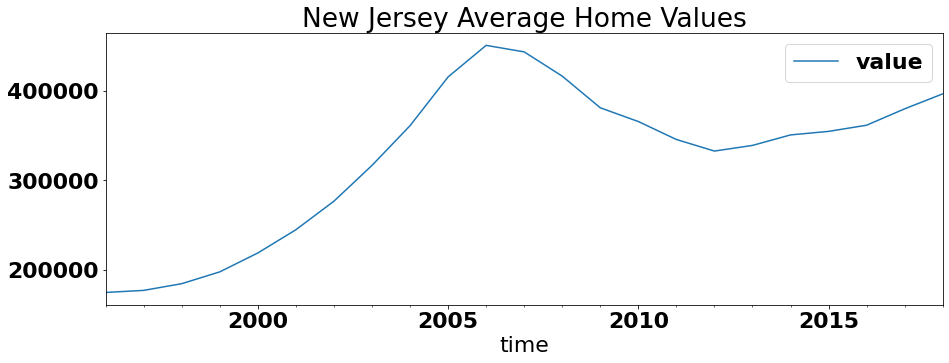

In [15]:
#Plot NJ average home values
nj_df.resample(rule='A').mean().plot(figsize=(15,5))
plt.title('New Jersey Average Home Values');

In [16]:
def adfuller_of(series):
    """Prints the Augmented Dickey-Fuller test results."""
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [17]:
#Perfrom Dickey-Fuller test to check for stationarity
#adfuller_of(nj_df['value'])

In [18]:
ROLL = 12

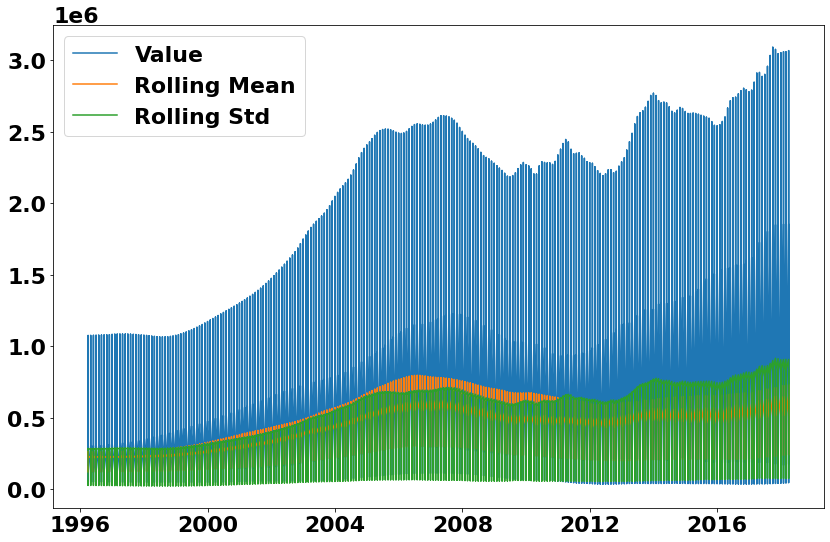

In [19]:
# Creating rolling mean and std.
nj_df['rolling_mean'] = nj_df['value'].rolling(window=ROLL).mean()
nj_df['rolling_std'] = nj_df['value'].rolling(window=ROLL).std()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(nj_df['value'], color='tab:blue', label='Value')
ax.plot(nj_df['rolling_mean'], color='tab:orange', label='Rolling Mean')
ax.plot(nj_df['rolling_std'], color='tab:green', label='Rolling Std')
ax.legend()
fig.tight_layout()

In [20]:
df_2 = pd.DataFrame(nj_df['value'])
df_2.head()

,value
time,
1996-04-01,301600.0
1996-04-01,153800.0
1996-04-01,123400.0
1996-04-01,145000.0
1996-04-01,137200.0


In [21]:
#decomposition = seasonal_decompose(df_2)

In [22]:
#Resample NJ data into yearly average
nj_df.resample(rule='A').mean()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,174862.239929,174892.158494,74934.079925
1997-12-31,177175.514608,177172.771414,76498.221217
1998-12-31,184681.308101,184673.113103,81131.432595
1999-12-31,197897.675963,197881.407703,90302.357218
2000-12-31,219015.454847,218995.179006,105237.013636
2001-12-31,244981.557105,244957.146414,121247.539011
2002-12-31,276909.130146,276875.477258,137009.835949
2003-12-31,316903.336653,316871.392209,153172.558460
2004-12-31,361307.719124,361261.739154,171456.425706


In [23]:
#Calculate NJ Return on Investment (ROI) from 1996-2018
 
def ROI(cost, value):
    ROI = (value-cost)/cost
    print(ROI)   

In [24]:
ROI(174862, 393831)

1.2522389083963354


 - Overall New Jersey ROI from 1996 through 2018 was 125%.

## Seperate Data into Individual Counties

In [25]:
#Check unique county names
melted_df[melted_df['State'] == 'NJ']['CountyName'].unique()

array(['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
       'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer',
       'Morris', 'Atlantic', 'Gloucester', 'Cumberland', 'Warren',
       'Hunterdon', 'Cape May', 'Sussex', 'Salem'], dtype=object)

### Hudson County Analysis

In [26]:
hudson_df = nj_df[(nj_df['CountyName'] == 'Hudson')]
hudson_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,NaN,NaN
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0,NaN,NaN
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,NaN,NaN
1996-04-01,60599,7093,West New York,NJ,New York,Hudson,215,131700.0,NaN,NaN
1996-04-01,60594,7087,Union City,NJ,New York,Hudson,320,127300.0,NaN,NaN


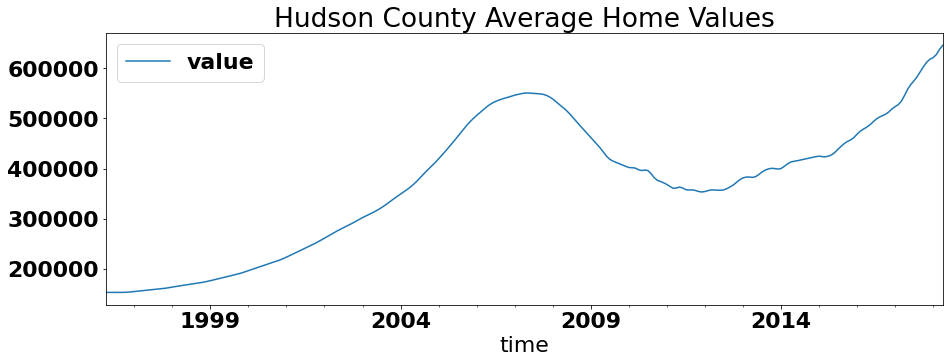

In [27]:
hudson_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Hudson County Average Home Values');

In [28]:
#Resample Hudson County data into yearly average
hudson_yearly = hudson_df.resample(rule='A').mean()
hudson_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,152799.145299,163214.545455,75561.620496
1997-12-31,158035.256410,166099.412393,79151.091981
1998-12-31,168750.000000,174404.273504,84918.041214
1999-12-31,184584.615385,188239.209402,96738.507282
2000-12-31,207874.358974,209923.985043,114257.422042


In [29]:
ROI(152799, 633382)

3.145197285322548


 - Hudson County ROI from 1996 through 2018 was 315%.

### Ocean County Analysis

In [30]:
ocean_df = nj_df[(nj_df['CountyName'] == 'Ocean')]
ocean_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0,NaN,NaN
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0,NaN,NaN
1996-04-01,61175,8759,Manchester,NJ,New York,Ocean,529,100900.0,NaN,NaN
1996-04-01,61093,8527,Jackson,NJ,New York,Ocean,569,151000.0,141858.333333,30462.688305
1996-04-01,61173,8757,Berkeley,NJ,New York,Ocean,1069,93200.0,165050.000000,61327.696546


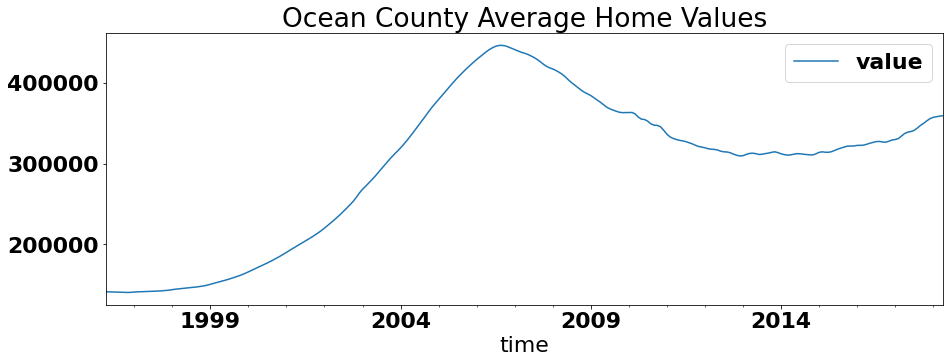

In [31]:
ocean_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Ocean County Average Home Values');

In [32]:
#Resample Ocean County data into yearly average
ocean_yearly = ocean_df.resample(rule='A').mean()
ocean_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,140976.628352,171419.832041,78278.514892
1997-12-31,142119.540230,173445.809387,79922.674544
1998-12-31,146608.333333,180545.833333,84248.083768
1999-12-31,156990.229885,193414.415709,93899.036334
2000-12-31,176511.494253,214308.812261,109881.692209


In [33]:
ROI(140977, 358358)

1.541960745369812


### Middlesex County Analysis

In [34]:
middlesex_df = nj_df[(nj_df['CountyName'] == 'Middlesex')]
middlesex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,61200,8831,Monroe,NJ,New York,Middlesex,279,218500.0,NaN,NaN
1996-04-01,61214,8854,Piscataway,NJ,New York,Middlesex,1044,161800.0,168375.000000,58073.356823
1996-04-01,61186,8816,East Brunswick,NJ,New York,Middlesex,1180,196000.0,163241.666667,55296.267478
1996-04-01,61187,8817,Edison,NJ,New York,Middlesex,1412,139200.0,173516.666667,65838.284432
1996-04-01,61219,8861,Perth Amboy,NJ,New York,Middlesex,1675,108000.0,156341.666667,51644.157609


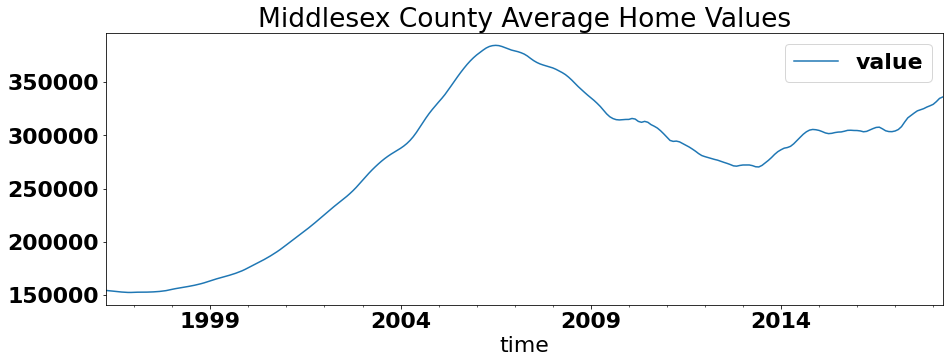

In [35]:
middlesex_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Middlesex County Average Home Values');

In [36]:
#Resample Middlesex County data into yearly average
middlesex_yearly = middlesex_df.resample(rule='A').mean()
middlesex_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,153361.437908,164153.907104,62359.523789
1997-12-31,153315.441176,166111.907680,64083.028461
1998-12-31,158667.156863,173085.069444,68376.891052
1999-12-31,168514.950980,184923.590686,76419.397907
2000-12-31,184768.872549,204218.198529,90101.134152


In [37]:
ROI(153361, 333029)

1.1715364401640573


### Somerset County Analysis

In [38]:
somerset_df = nj_df[(nj_df['CountyName'] == 'Somerset')]
somerset_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,61229,8873,Franklin,NJ,New York,Somerset,550,161100.0,154408.333333,55392.425776
1996-04-01,61208,8844,Hillsborough,NJ,New York,Somerset,1942,227200.0,141000.000000,43765.926971
1996-04-01,61181,8807,Bridgewater,NJ,New York,Somerset,2230,222600.0,132475.000000,54135.270388
1996-04-01,60864,7920,Bernards,NJ,New York,Somerset,4073,354600.0,180191.666667,74883.867158
1996-04-01,61231,8876,Branchburg,NJ,New York,Somerset,4987,177200.0,137341.666667,46589.063452


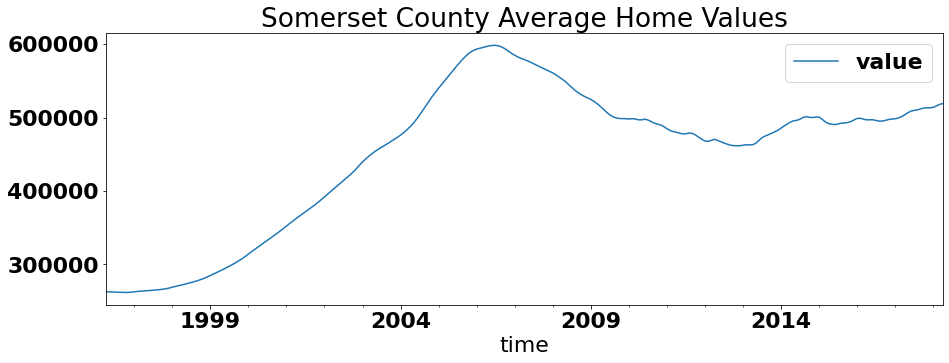

In [39]:
somerset_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Somerset County Average Home Values');

In [40]:
#Resample Somerset County data into yearly average
somerset_yearly = somerset_df.resample(rule='A').mean()
somerset_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,262227.513228,181553.880071,88642.616046
1997-12-31,264880.555556,184065.575397,90404.784742
1998-12-31,275220.634921,191873.148148,95684.848109
1999-12-31,297008.730159,205861.144180,106501.969957
2000-12-31,331385.714286,227620.568783,122930.155658


In [41]:
ROI(262228, 516805)

0.970823100507955


### Monmouth County Analysis

In [42]:
monmouth_df = nj_df[(nj_df['CountyName'] == 'Monmouth')]
monmouth_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60776,7728,Freehold,NJ,New York,Monmouth,577,200200.0,145725.000000,34758.207010
1996-04-01,60763,7712,Ocean,NJ,New York,Monmouth,1110,159300.0,166708.333333,60779.548868
1996-04-01,60774,7726,Manalapan,NJ,New York,Monmouth,1499,205700.0,157616.666667,52562.808029
1996-04-01,60793,7753,Neptune,NJ,New York,Monmouth,1704,119400.0,156891.666667,51171.271385
1996-04-01,60786,7740,Long Branch,NJ,New York,Monmouth,2483,116100.0,120558.333333,43164.072989


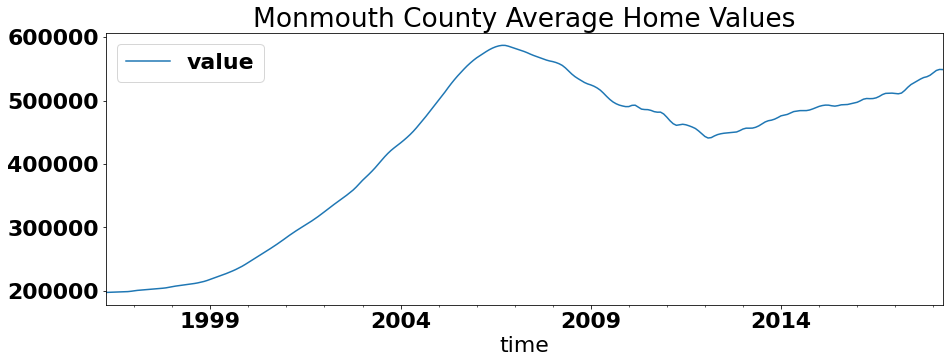

In [43]:
monmouth_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Monmouth County Average Home Values');

In [44]:
#Resample Monmouth County data into yearly average
monmouth_yearly = monmouth_df.resample(rule='A').mean()
monmouth_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,197961.229314,178857.840820,72343.837604
1997-12-31,202424.468085,181367.833924,73746.021921
1998-12-31,210641.134752,188998.034870,78404.805511
1999-12-31,228644.503546,203203.472222,87882.241358
2000-12-31,262084.751773,226187.189716,103330.517754


In [45]:
ROI(197961, 547321)

1.7647920550007326


### Passaic County Analysis

In [46]:
#Create Passaic County dataframe
passaic_df = nj_df[(nj_df['CountyName'] == 'Passaic')]
passaic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60565,7055,Passaic,NJ,New York,Passaic,623,133100.0,146533.333333,34301.612295
1996-04-01,60688,7470,Wayne,NJ,New York,Passaic,841,240400.0,144466.666667,43737.010193
1996-04-01,60527,7011,Clifton,NJ,New York,Passaic,3129,147600.0,146708.333333,36616.699080
1996-04-01,60529,7013,Clifton,NJ,New York,Passaic,3969,170800.0,143741.666667,38928.149626
1996-04-01,60694,7501,Paterson,NJ,New York,Passaic,4045,105400.0,167033.333333,51751.228942


In [47]:
#Take the mean of each Passaic County value
passaic_average = passaic_df.groupby('time').aggregate({'value':'mean'})
passaic_average

,value
time,
1996-04-01,149352.0
1996-05-01,149192.0
1996-06-01,149036.0
1996-07-01,148872.0
1996-08-01,148736.0
...,...
2017-12-01,286644.0
2018-01-01,289556.0
2018-02-01,293160.0


In [48]:
passaic_yearly = passaic_df.resample(rule='A').mean()
passaic_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,148886.222222,172640.888889,68991.860534
1997-12-31,150718.666667,175295.277778,70315.577723
1998-12-31,154783.000000,183549.333333,75209.986186
1999-12-31,163154.666667,196553.694444,83830.664892
2000-12-31,177700.000000,217643.527778,97805.631710


In [49]:
ROI(148886, 294859)

0.9804346950015448


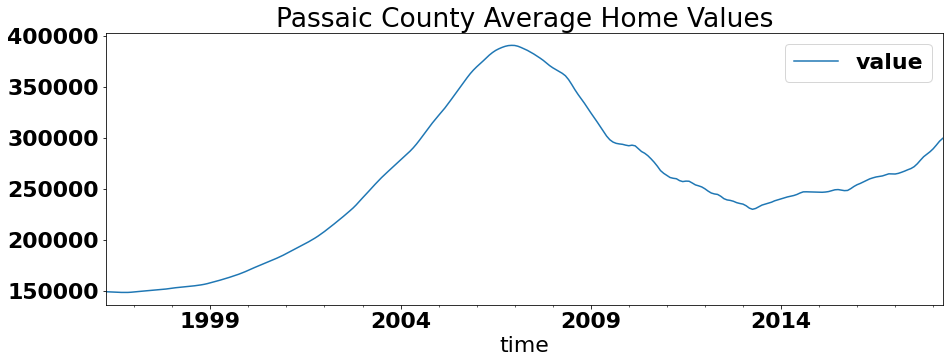

In [50]:
passaic_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Passaic County Average Home Values');

In [51]:
#Check unique cities for Passaic County
passaic_df.City.unique()

array(['Passaic', 'Wayne', 'Clifton', 'Paterson', 'Little Falls',
       'North Haledon', 'Hawthorne', 'West Milford', 'Ringwood',
       'Pompton Lakes', 'Totowa', 'Bloomingdale', 'Wanaque'], dtype=object)

<AxesSubplot:xlabel='time'>

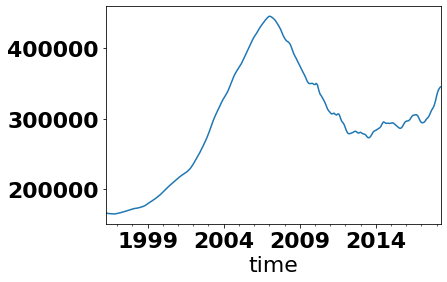

In [52]:
passaic_df.loc[passaic_df['City'] == 'North Haledon']['value'].plot()

<AxesSubplot:xlabel='time'>

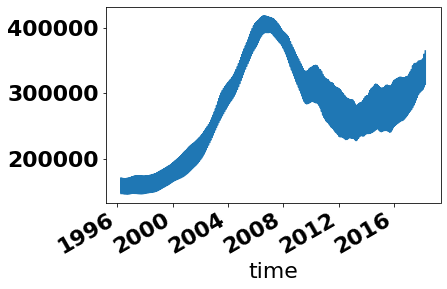

In [53]:
passaic_df.loc[passaic_df['City'] == 'Clifton']['value'].plot() 

### Essex County Analysis

In [54]:
essex_df = nj_df[(nj_df['CountyName'] == 'Essex')]
essex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60519,7003,Bloomfield,NJ,New York,Essex,642,140800.0,146183.333333,34340.086126
1996-04-01,60608,7104,Newark,NJ,New York,Essex,1115,114100.0,169150.000000,57700.488418
1996-04-01,60563,7052,West Orange,NJ,New York,Essex,1171,165300.0,160116.666667,54327.823666
1996-04-01,60609,7105,Newark,NJ,New York,Essex,1797,164500.0,132216.666667,33926.895561
1996-04-01,60613,7109,Belleville,NJ,New York,Essex,2698,123400.0,139191.666667,49487.454027


In [55]:
essex_yearly = essex_df.resample(rule='A').mean()
essex_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,196322.666667,164612.888889,63140.918127
1997-12-31,200011.666667,166973.694444,63693.162352
1998-12-31,219951.666667,175212.277778,68732.590695
1999-12-31,235872.666667,186983.916667,76649.004924
2000-12-31,262101.333333,206171.083333,88838.475383


In [56]:
ROI(196323, 515671)

1.6266458845881533


### Camden County Analysis

In [57]:
camden_df = nj_df[(nj_df['CountyName'] == 'Camden')]
camden_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60916,8021,Lindenwold,NJ,Philadelphia,Camden,679,84800.0,140125.000000,39564.151014
1996-04-01,60971,8081,Winslow,NJ,Philadelphia,Camden,1099,112800.0,162716.666667,62848.024968
1996-04-01,60909,8012,Gloucester,NJ,Philadelphia,Camden,1775,115100.0,152000.000000,53837.212544
1996-04-01,60936,8043,Voorhees,NJ,Philadelphia,Camden,3046,180300.0,140866.666667,38927.796410
1996-04-01,60900,8003,Cherry Hill,NJ,Philadelphia,Camden,3552,170500.0,125166.666667,41423.145338


In [58]:
camden_yearly = camden_df.resample(rule='A').mean()
camden_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,105613.793103,168274.680715,66064.651913
1997-12-31,105889.655172,170241.211686,67582.774945
1998-12-31,107482.758621,177136.733716,72378.337811
1999-12-31,110516.954023,189579.789272,80946.603553
2000-12-31,114424.425287,209165.589080,94490.946374


In [59]:
ROI(105614, 192142)

0.8192853220217017


### Bergen County Analysis

In [60]:
bergen_df = nj_df[(nj_df['CountyName'] == 'Bergen')]
bergen_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60714,7601,Hackensack,NJ,New York,Bergen,833,157500.0,135041.666667,31719.952377
1996-04-01,60540,7024,Fort Lee,NJ,New York,Bergen,948,260200.0,161641.666667,49960.683785
1996-04-01,60750,7666,Teaneck,NJ,New York,Bergen,2344,170800.0,136408.333333,53293.295815
1996-04-01,60656,7410,Fair Lawn,NJ,New York,Bergen,3204,180500.0,143816.666667,28587.976918
1996-04-01,60729,7631,Englewood,NJ,New York,Bergen,3954,163300.0,138158.333333,39495.119568


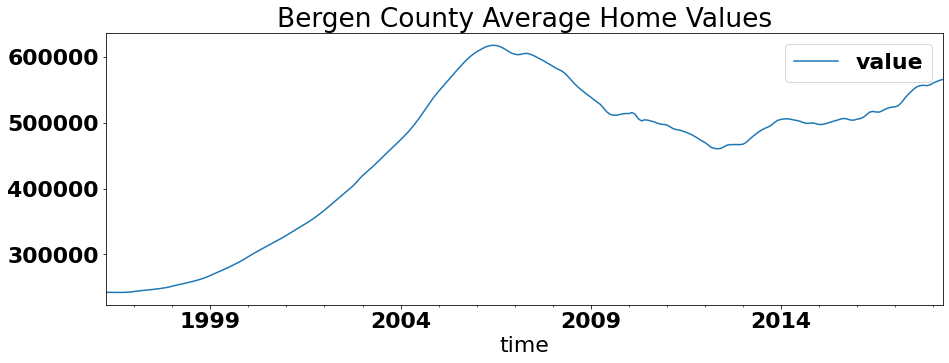

In [61]:
bergen_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Bergen County Average Home Values');

In [62]:
bergen_df.groupby('time').aggregate({'value':'mean'})

,value
time,
1996-04-01,242570.769231
1996-05-01,242533.846154
1996-06-01,242498.461538
1996-07-01,242446.153846
1996-08-01,242430.769231
...,...
2017-12-01,557272.307692
2018-01-01,560176.923077
2018-02-01,562172.307692


In [63]:
bergen_yearly = bergen_df.resample(rule='A').mean()
bergen_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,242617.435897,181099.886040,74820.356815
1997-12-31,246987.435897,183595.000000,76585.173263
1998-12-31,258393.974359,191628.055556,81382.732627
1999-12-31,280335.000000,205818.023504,90771.826824
2000-12-31,311589.743590,228019.786325,106065.569672


In [64]:
ROI(242617, 563004)

1.3205463755631304


In [65]:
bergen_cities = bergen_df.groupby(['time', 'City']).aggregate({'value':'mean'})
bergen_cities.head()

value
time       City                  
1996-04-01 Allendale     294000.0
           Alpine       1075400.0
           Bergenfield   161100.0
           Bogota        151400.0
           Carlstadt     169800.0

In [66]:
bergen_df.groupby(['time', 'City'])['value'].mean()

time        City          
1996-04-01  Allendale          294000.0
            Alpine            1075400.0
            Bergenfield        161100.0
            Bogota             151400.0
            Carlstadt          169800.0
                                ...    
2018-04-01  Wallington         370300.0
            Washington         506500.0
            Wood Ridge         405700.0
            Woodcliff Lake     739100.0
            Wyckoff            713700.0
Name: value, Length: 17225, dtype: float64

In [67]:
#bergen_cities.resample(rule='A').mean()

### Burlington County Analysis

In [68]:
burlington_df = nj_df[(nj_df['CountyName'] == 'Burlington')]
burlington_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60945,8054,Mt Laurel,NJ,Philadelphia,Burlington,851,158500.0,148908.333333,42061.112645
1996-04-01,60944,8053,Evesham,NJ,Philadelphia,Burlington,917,149400.0,153383.333333,39225.358990
1996-04-01,60912,8016,Burlington,NJ,Philadelphia,Burlington,2893,121100.0,143291.666667,45263.379907
1996-04-01,60938,8046,Willingboro,NJ,Philadelphia,Burlington,3535,89600.0,142275.000000,48155.961115
1996-04-01,60965,8075,Delran,NJ,Philadelphia,Burlington,3550,117400.0,129575.000000,48837.506544


In [69]:
burlington_yearly = burlington_df.resample(rule='A').mean()
burlington_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,133882.608696,165011.473430,63772.664028
1997-12-31,135069.927536,167193.961353,65293.407644
1998-12-31,137379.710145,174520.199275,70326.857690
1999-12-31,141843.840580,186613.435990,78965.214535
2000-12-31,148648.913043,205784.933575,91895.876958


In [70]:
ROI(133883, 244695)

0.8276778978660472


### Union County Analysis

In [71]:
union_df = nj_df[(nj_df['CountyName'] == 'Union')]
union_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60592,7083,Union,NJ,New York,Union,862,152400.0,153200.000000,39250.801961
1996-04-01,60551,7036,Linden,NJ,New York,Union,1582,131700.0,155108.333333,53060.864851
1996-04-01,60569,7060,Plainfield,NJ,New York,Union,2282,126300.0,134200.000000,53527.444108
1996-04-01,60632,7202,Elizabeth,NJ,New York,Union,2350,123000.0,139991.666667,50529.675499
1996-04-01,60574,7065,Rahway,NJ,New York,Union,3396,126400.0,148091.666667,38419.750090


In [72]:
union_yearly = union_df.resample(rule='A').mean()
union_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,169182.905983,165140.740741,66651.468406
1997-12-31,171675.641026,167064.316239,67598.243556
1998-12-31,178750.320513,174034.001068,72064.828901
1999-12-31,192007.371795,185568.295940,79954.362129
2000-12-31,212806.410256,204580.715812,92544.165361


In [73]:
ROI(169183, 393559)

1.3262325410945544


### Mercer County Analysis

In [74]:
mercer_df = nj_df[(nj_df['CountyName'] == 'Mercer')]
mercer_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,61100,8540,Princeton,NJ,Trenton,Mercer,989,270200.0,171575.000000,58732.353249
1996-04-01,61129,8618,Trenton,NJ,Trenton,Mercer,2418,74700.0,132508.333333,53151.643408
1996-04-01,61141,8648,Lawrence,NJ,Trenton,Mercer,3098,161000.0,144083.333333,37661.164790
1996-04-01,61127,8610,Hamilton,NJ,Trenton,Mercer,3310,100500.0,150433.333333,37829.265567
1996-04-01,61090,8520,East Windsor,NJ,Trenton,Mercer,3909,139500.0,131775.000000,41214.960324


In [75]:
mercer_yearly = mercer_df.resample(rule='A').mean()
mercer_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,157605.882353,165988.344227,61134.596060
1997-12-31,157496.568627,167932.189542,62306.285993
1998-12-31,162875.490196,175294.117647,66953.276696
1999-12-31,172675.980392,187241.053922,74677.778958
2000-12-31,189482.352941,206638.807190,87391.163760


In [76]:
ROI(157606, 326565)

1.0720340596170197


### Morris County Analysis

In [77]:
morris_df = nj_df[(nj_df['CountyName'] == 'Morris')]
morris_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60884,7960,Morris,NJ,New York,Morris,1281,285900.0,174366.666667,65419.476296
1996-04-01,60564,7054,Parsippany-Troy Hills,NJ,New York,Morris,3444,220700.0,155216.666667,43739.410840
1996-04-01,60848,7869,Randolph,NJ,New York,Morris,4926,253900.0,155283.333333,62015.259608
1996-04-01,60847,7866,Rockaway,NJ,New York,Morris,5332,165800.0,168358.333333,66604.769940
1996-04-01,60806,7801,Dover,NJ,New York,Morris,5527,134200.0,179033.333333,82823.660797


In [78]:
morris_yearly = morris_df.resample(rule='A').mean()
morris_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,214270.801034,186316.688200,81651.311661
1997-12-31,218391.860465,188864.567183,83430.192834
1998-12-31,230183.720930,196804.231266,88432.389991
1999-12-31,248456.201550,211195.833333,98193.329410
2000-12-31,274338.178295,234061.934755,114354.098113


In [79]:
ROI(214271, 442678)

1.0659725301137344


### Atlantic County Analysis

In [80]:
atlantic_df = nj_df[(nj_df['CountyName'] == 'Atlantic')]
atlantic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,61021,8234,Egg Harbor,NJ,Atlantic City,Atlantic,1481,133900.0,162991.666667,60608.767118
1996-04-01,61056,8330,Hamilton,NJ,Atlantic City,Atlantic,3530,103800.0,147108.333333,45208.938343
1996-04-01,61003,8205,Galloway,NJ,Atlantic City,Atlantic,3758,116600.0,125825.000000,38572.390621
1996-04-01,60931,8037,Hammonton,NJ,Atlantic City,Atlantic,4930,97000.0,152008.333333,64111.188335
1996-04-01,61079,8406,Ventnor City,NJ,Atlantic City,Atlantic,6415,119300.0,197891.666667,57818.249059


In [81]:
atlantic_yearly = atlantic_df.resample(rule='A').mean()
atlantic_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,120472.839506,186744.187243,118342.396862
1997-12-31,122237.037037,189256.481481,119794.177718
1998-12-31,127413.425926,197313.695988,123863.350635
1999-12-31,132551.851852,210705.632716,133736.922651
2000-12-31,141418.981481,232156.211420,151619.434096


In [82]:
ROI(120473, 236446)

0.962647232159903


### Gloucester County Analysis

In [83]:
gloucester_df = nj_df[(nj_df['CountyName'] == 'Gloucester')]
gloucester_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60983,8094,Monroe,NJ,Philadelphia,Gloucester,1745,105600.0,152433.333333,53234.410152
1996-04-01,60985,8096,Deptford,NJ,Philadelphia,Gloucester,2060,99600.0,130116.666667,40712.379920
1996-04-01,60970,8080,Washington,NJ,Philadelphia,Gloucester,2330,140000.0,131766.666667,52444.469911
1996-04-01,60922,8028,Glassboro,NJ,Philadelphia,Gloucester,5606,106100.0,173233.333333,85580.704424
1996-04-01,60974,8085,Woolwich,NJ,Philadelphia,Gloucester,6170,149300.0,146575.000000,52496.720677


In [84]:
gloucester_yearly = gloucester_df.resample(rule='A').mean()
gloucester_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,114002.020202,179138.678451,92128.884936
1997-12-31,115370.454545,181174.084596,93755.178258
1998-12-31,117593.181818,186959.722222,96603.042471
1999-12-31,120898.106061,199930.176768,106178.564172
2000-12-31,126798.863636,221608.743687,123575.102216


In [85]:
ROI(114002, 201674)

0.7690391396642164


### Cumberland County Analysis

In [86]:
cumberland_df = nj_df[(nj_df['CountyName'] == 'Cumberland')]
cumberland_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,61071,8360,Vineland,NJ,Vineland,Cumberland,1779,80000.0,142333.333333,55603.765951
1996-04-01,61036,8302,Bridgeton,NJ,Vineland,Cumberland,2116,75500.0,127408.333333,43315.217950
1996-04-01,61057,8332,Millville,NJ,Vineland,Cumberland,2221,71900.0,123450.000000,46188.654648
1996-04-01,61072,8361,Vineland,NJ,Vineland,Cumberland,6380,113200.0,185691.666667,55432.390569
1996-05-01,61071,8360,Vineland,NJ,Vineland,Cumberland,1779,80000.0,142091.666667,55462.132181


In [87]:
cumberland_yearly = cumberland_df.resample(rule='A').mean()
cumberland_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,84952.777778,144217.592593,49896.188159
1997-12-31,84695.833333,145515.277778,50839.049114
1998-12-31,86625.000000,151026.736111,54176.112387
1999-12-31,88760.416667,160123.437500,60145.006402
2000-12-31,90743.750000,174598.958333,69572.895647


In [88]:
ROI(84953, 142456)

0.676880157263428


### Warren County Analysis

In [89]:
warren_df = nj_df[(nj_df['CountyName'] == 'Warren')]
warren_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60828,7840,Hackettstown,NJ,Allentown,Warren,2987,154500.0,137616.666667,38121.643419
1996-04-01,61222,8865,Phillipsburg,NJ,Allentown,Warren,3080,98700.0,138841.666667,40540.338123
1996-04-01,60859,7882,Washington,NJ,Allentown,Warren,6995,133700.0,158475.000000,47724.533904
1996-04-01,60814,7825,Blairstown,NJ,Allentown,Warren,9049,171000.0,197216.666667,71301.483261
1996-04-01,60813,7823,Belvidere,NJ,Allentown,Warren,9157,126800.0,196833.333333,67731.842026


In [90]:
warren_yearly = warren_df.resample(rule='A').mean()
warren_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,150986.666667,182896.666667,70349.954924
1997-12-31,150546.666667,184928.611111,71632.873529
1998-12-31,154488.333333,191938.819444,75275.930769
1999-12-31,161905.833333,204794.166667,82941.683841
2000-12-31,173858.333333,225468.611111,95452.982699


In [91]:
ROI(150987, 247808)

0.6412538827846106


### Hunterdon County Analysis

In [92]:
hunterdon_df = nj_df[(nj_df['CountyName'] == 'Hunterdon')]
hunterdon_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,61191,8822,Raritan,NJ,New York,Hunterdon,3254,223400.0,152150.000000,35768.612447
1996-04-01,61241,8889,Readington,NJ,New York,Hunterdon,8617,236000.0,196341.666667,76656.583164
1996-04-01,61202,8833,Clinton,NJ,New York,Hunterdon,8917,276400.0,171350.000000,65386.049388
1996-04-01,61095,8530,Lambertville,NJ,New York,Hunterdon,9026,173700.0,195025.000000,72573.450254
1996-04-01,61210,8848,Holland,NJ,New York,Hunterdon,9267,177100.0,175516.666667,82168.461472


In [93]:
hunterdon_yearly = hunterdon_df.resample(rule='A').mean()
hunterdon_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,208477.160494,185820.781893,84045.121936
1997-12-31,207426.388889,187973.495370,85314.834438
1998-12-31,213071.759259,194880.787037,89368.874994
1999-12-31,228738.425926,209618.518519,99324.732479
2000-12-31,254743.055556,232853.240741,116202.857387


In [94]:
ROI(208477, 368418)

0.7671877473294416


### Cape May County Analysis

In [95]:
cape_may_df = nj_df[(nj_df['CountyName'] == 'Cape May')]
cape_may_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,61017,8226,Ocean City,NJ,Ocean City,Cape May,3631,182400.0,137850.000000,47412.071727
1996-04-01,61002,8204,Lower,NJ,Ocean City,Cape May,4537,107700.0,171358.333333,57537.378496
1996-04-01,61004,8210,Middle,NJ,Ocean City,Cape May,5878,93300.0,136958.333333,44347.377873
1996-04-01,61034,8260,North Wildwood,NJ,Ocean City,Cape May,6038,89500.0,134600.000000,45902.703426
1996-04-01,61032,8251,Villas,NJ,Ocean City,Cape May,7399,61800.0,167250.000000,89446.047730


In [96]:
cape_may_yearly = cape_may_df.resample(rule='A').mean()
cape_may_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,164170.370370,177732.253086,74144.793396
1997-12-31,168698.611111,180638.946759,76335.017805
1998-12-31,179461.111111,188987.268519,82187.054198
1999-12-31,203982.638889,203766.493056,93224.696922
2000-12-31,248079.166667,227446.759259,111395.266605


In [97]:
ROI(164170, 592579)

2.609544983858196


### Sussex County Analysis

In [98]:
sussex_df = nj_df[(nj_df['CountyName'] == 'Sussex')]
sussex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60844,7860,Newton,NJ,New York,Sussex,4412,136300.0,175416.666667,70956.014971
1996-04-01,60850,7871,Sparta,NJ,New York,Sussex,5720,190000.0,139366.666667,36597.300778
1996-04-01,60684,7461,Wantage,NJ,New York,Sussex,6188,137500.0,150258.333333,49905.628364
1996-04-01,60830,7843,Hopatcong,NJ,New York,Sussex,7883,121200.0,152608.333333,61157.225966
1996-04-01,60660,7419,Hardyston,NJ,New York,Sussex,8472,134300.0,204391.666667,106244.490410


In [99]:
sussex_yearly = sussex_df.resample(rule='A').mean()
sussex_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,139554.074074,179925.370370,73337.529670
1997-12-31,139401.666667,181995.555556,75075.513303
1998-12-31,141914.444444,189461.157407,80249.464000
1999-12-31,149538.888889,203286.250000,90186.710432
2000-12-31,161577.777778,224391.527778,104280.217065


In [100]:
ROI(139554, 229287)

0.6429984092179372


### Salem County Analysis

In [101]:
salem_df = nj_df[(nj_df['CountyName'] == 'Salem')]
salem_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60960,8070,Pennsville,NJ,Philadelphia,Salem,7321,90700.0,212925.000000,96556.710844
1996-04-01,60959,8069,Carneys Point,NJ,Philadelphia,Salem,7541,70500.0,130283.333333,51492.626715
1996-04-01,61045,8318,Pittsgrove,NJ,Philadelphia,Salem,7902,89000.0,128158.333333,38739.818799
1996-04-01,60969,8079,Salem,NJ,Philadelphia,Salem,8038,68000.0,123575.000000,46161.989972
1996-04-01,60987,8098,Pilesgrove,NJ,Philadelphia,Salem,8960,106000.0,173250.000000,70803.370490


In [102]:
salem_yearly = salem_df.resample(rule='A').mean()
salem_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,84092.592593,166902.160494,97939.935262
1997-12-31,85593.055556,169428.587963,100236.955200
1998-12-31,90959.722222,176091.319444,103219.213077
1999-12-31,95869.444444,187705.787037,111141.932877
2000-12-31,101059.722222,205226.157407,126517.689474


In [103]:
ROI(84093, 147042)

0.7485640897577682


## Top ROI Counties

In [104]:
data = {'Average Return on Investment %':[315, 154, 117, 97, 176, 98, 163, 82, 132, 83, 133, 107, 107, 96, 77, 68,
                                       64, 77, 261, 64, 75]}
roi_comparison = pd.DataFrame(data, index=['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
                                          'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer', 'Morris',
                                          'Atlantic', 'Gloucester', 'Cumberland', 'Warren', 'Hunterdon',
                                          'Cape May', 'Sussex', 'Salem'])
roi_comparison.sort_values(by=['Average Return on Investment %'], ascending=False).head()

,Average Return on Investment %
Hudson,315
Cape May,261
Monmouth,176
Essex,163
Ocean,154


In [153]:
hudson_yearly = hudson_df['value'].resample(rule='A').mean()
cape_may_yearly = cape_may_df['value'].resample(rule='A').mean()
monmouth_yearly = monmouth_df['value'].resample(rule='A').mean()

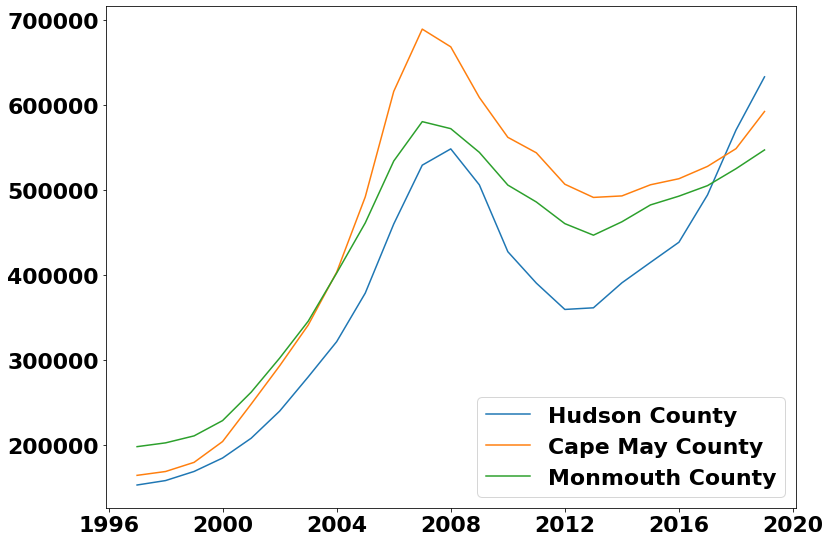

In [155]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hudson_yearly, color='tab:blue', label='Hudson County')
ax.plot(cape_may_yearly, color='tab:orange', label='Cape May County')
ax.plot(monmouth_yearly, color='tab:green', label='Monmouth County')
ax.legend()
fig.tight_layout()

## ARIMA Modeling

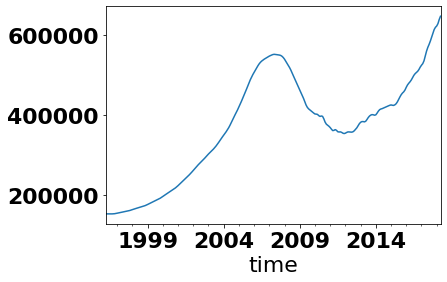

In [131]:
hudson_monthly = hudson_df.resample(rule='M').mean()
hudson_monthly['value'].plot();

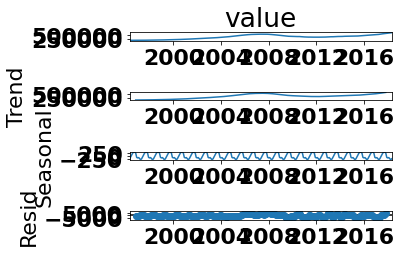

In [136]:
result = seasonal_decompose(hudson_monthly['value'])
result.plot();

In [141]:
stepwise_fit = auto_arima(hudson_monthly['value'], trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5020.377, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5107.194, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5073.207, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5080.000, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5162.038, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5040.837, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4998.435, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4995.994, Time=0.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5065.934, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5072.926, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5002.610, Time=0.56 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.591 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2493.997
Date:                Thu, 13 May 2021   AIC                           4995.994
Time:                        14:56:31   BIC                           5010.298
Sample:                             0   HQIC                          5001.741
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     68.6273     34.672      1.979      0.048       0.672     136.582
ar.L1          0.9343      0.016     57.300      0.000       0.902       0.966
ma.L1         -0.8756      0.020    -42.871      0.000      -0.916      -0.836
sigma2      8.785e+06      0.000   1.79e+10      0.000    8.78e+06    8.78e+06
===================================================================================
Ljung-Box (L1) (Q):                 211.20   Jarque-Bera (JB):                49.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.73
Prob(H) (two-sided):                  0.45   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.55e+25. Standard errors may be unstable.
"""

In [143]:
len(hudson_monthly)

265

In [146]:
train = hudson_monthly.iloc[:205]
test = hudson_monthly.iloc[205:]

In [147]:
model = ARIMA(train['value'], order=(1,1,1))
results = model.fit()
results.summary()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [106]:
hudson_mean = hudson_df.groupby('time').aggregate({'value':'mean'})
hudson_mean.head()

,value
time,
1996-04-01,152669.230769
1996-05-01,152638.461538
1996-06-01,152607.692308
1996-07-01,152561.538462
1996-08-01,152561.538462


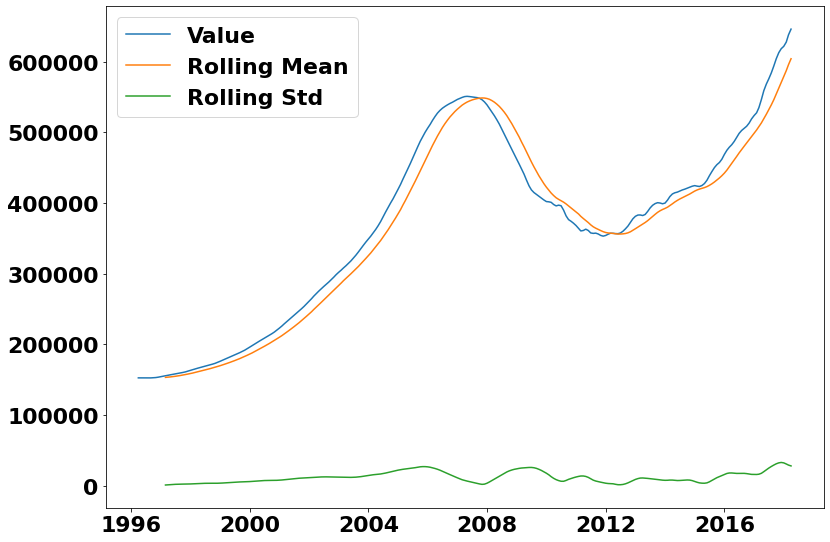

In [107]:
# Creating rolling mean and std.
hudson_mean['rolling_mean'] = hudson_mean['value'].rolling(window=ROLL).mean()
hudson_mean['rolling_std'] = hudson_mean['value'].rolling(window=ROLL).std()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hudson_mean['value'], color='tab:blue', label='Value')
ax.plot(hudson_mean['rolling_mean'], color='tab:orange', label='Rolling Mean')
ax.plot(hudson_mean['rolling_std'], color='tab:green', label='Rolling Std')
ax.legend()
fig.tight_layout()

In [108]:
#decomposition = seasonal_decompose(hudson_mean['value'])
#decomposition.plot()

In [109]:
hudson_value = hudson_mean[['value']]

In [110]:
hudson_shift_12 = hudson_value.shift(periods=12)

lag_12 = pd.concat([hudson_shift_12, hudson_value], axis=1)

lag_12.corr()

,value,value
value,1.000000,0.944629
value,0.944629,1.000000


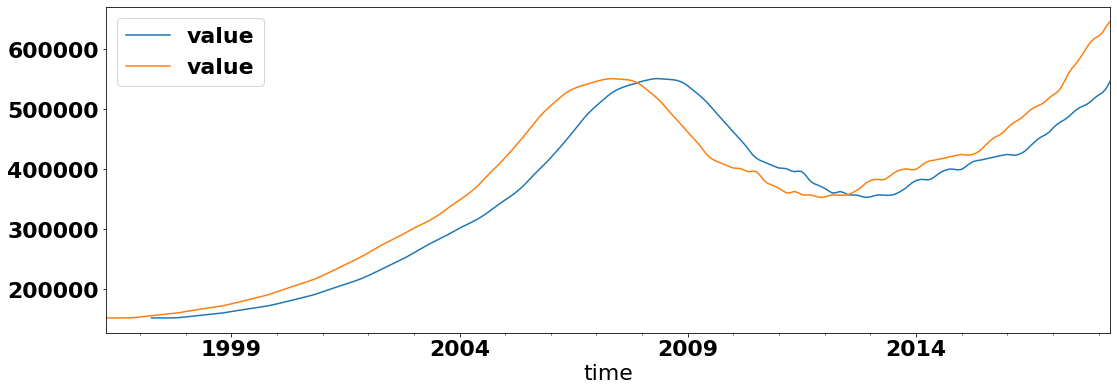

In [111]:
lag_12.plot(figsize=(18,6));

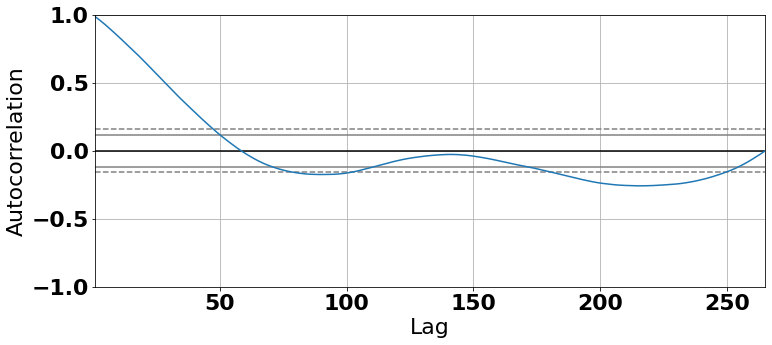

In [112]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(hudson_value);

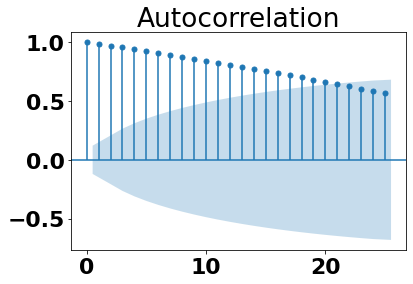

In [113]:
#Plot the autocorrelation function
plot_acf(hudson_value);

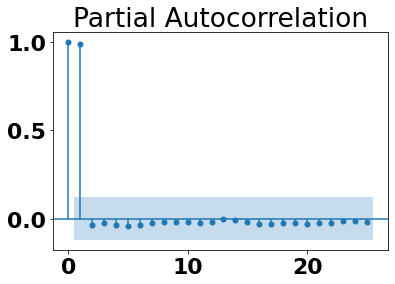

In [114]:
plot_pacf(hudson_value);

In [115]:
hudson_df_v

time
1996-04-01    301600.0
1996-04-01    145000.0
1996-04-01    137200.0
1996-04-01    131700.0
1996-04-01    127300.0
                ...   
2018-04-01    546600.0
2018-04-01    343200.0
2018-04-01    520400.0
2018-04-01    836100.0
2018-04-01    377000.0
Name: value, Length: 3445, dtype: float64

In [116]:
arima_model = ARIMA(hudson_df_v, order=(1,1,1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                 3444
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -47223.844
Method:                       css-mle   S.D. of innovations         218128.537
Date:                Thu, 13 May 2021   AIC                          94455.687
Time:                        10:52:00   BIC                          94480.265
Sample:                             1   HQIC                         94464.466
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.8931   1812.952      0.012      0.990   -3531.427    3575.213
ar.L1.D.value    -0.7125      0.015    -49.005      0.000      -0.741      -0.684
ma.L1.D.value    -0.1648      0.019     -8.773      0.000      -0.202      -0.128
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4034           +0.0000j            1.4034            0.5000
MA.1            6.0663           +0.0000j            6.0663            0.0000
-----------------------------------------------------------------------------
"""

In [117]:
arima_model.aic

94455.6874157353

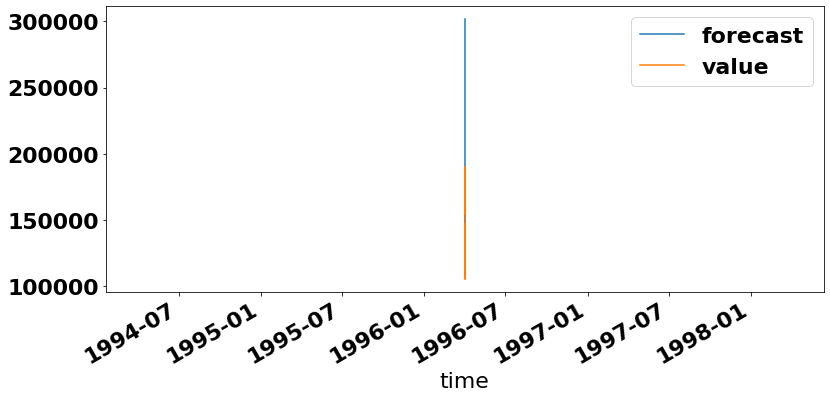

In [119]:
fig, ax = plt.subplots(figsize=(12, 6))
arima_model.plot_predict(1, 12, ax=ax)
fig.tight_layout()

## SARIMA Modeling

In [156]:
auto_arima(hudson_monthly['value'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -2493.679
Date:                Thu, 13 May 2021   AIC                           4999.358
Time:                        15:55:24   BIC                           5020.814
Sample:                             0   HQIC                          5007.980
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     90.8769     43.061      2.110      0.035       6.480     175.274
ar.L1          0.9270      0.022     41.676      0.000       0.883       0.971
ma.L1         -0.8642      0.025    -35.200      0.000      -0.912      -0.816
ma.L2         -0.0127      0.009     -1.465      0.143      -0.030       0.004
ma.L3          0.0123      0.008      1.473      0.141      -0.004       0.029
sigma2      8.945e+06      0.001   1.01e+10      0.000    8.94e+06    8.94e+06
===================================================================================
Ljung-Box (L1) (Q):                 209.32   Jarque-Bera (JB):                55.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.76
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+26. Standard errors may be unstable.
"""

In [157]:
len(hudson_monthly)

265

In [162]:
train_2 = hudson_monthly.iloc[:229]
test_2 = hudson_monthly.iloc[229:]

In [160]:
model_2 = SARIMAX(hudson_monthly['value'], order = (1,1,3))

In [161]:
results = model_2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -2529.511
Date:                Thu, 13 May 2021   AIC                           5069.022
Time:                        16:01:48   BIC                           5086.902
Sample:                    04-30-1996   HQIC                          5076.207
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.002    473.537      0.000       0.995       1.003
ma.L1         -0.8887      0.006   -151.697      0.000      -0.900      -0.877
ma.L2         -0.0161      0.008     -1.919      0.055      -0.033       0.000
ma.L3         -0.0909      0.010     -8.759      0.000      -0.111      -0.071
sigma2      1.201e+07   1.68e-11   7.14e+17      0.000     1.2e+07     1.2e+07
===================================================================================
Ljung-Box (L1) (Q):                 195.66   Jarque-Bera (JB):               146.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -1.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.09e+33. Standard errors may be unstable.
"""

In [163]:
start = len(train_2)
end = len(train_2) + len(test) - 1

In [164]:
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

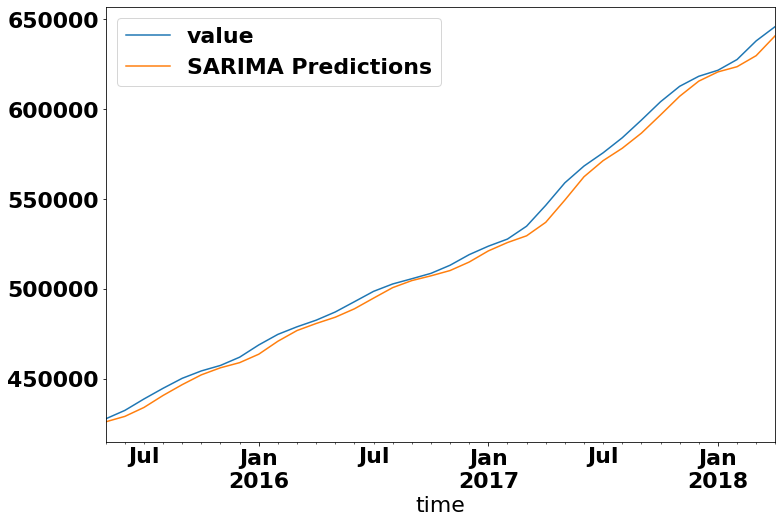

In [166]:
test['value'].plot(legend=True,figsize=(12,8))
predictions.plot(legend=True);

In [167]:
future_model = SARIMAX(hudson_monthly['value'], order = (1,1,3))
results_future = future_model.fit()

In [168]:
fcast = results_future.predict(len(hudson_monthly), len(hudson_monthly)+11, typ='levels').rename('SARIMA Forecast')

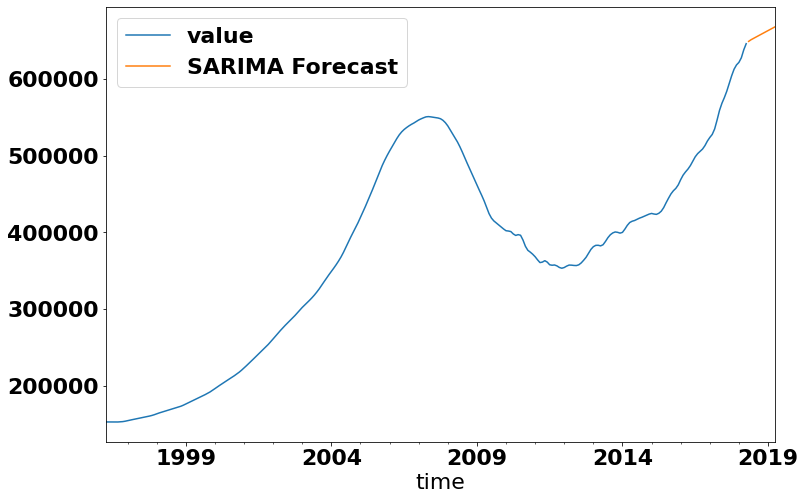

In [170]:
hudson_monthly['value'].plot(legend=True, figsize=(12,8))
fcast.plot(legend=True);

## Facebook Prophet Model